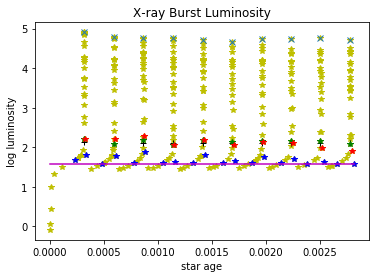

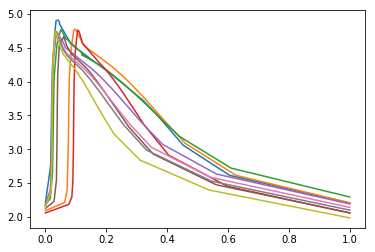

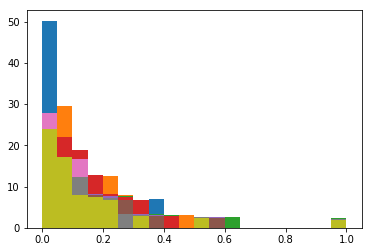

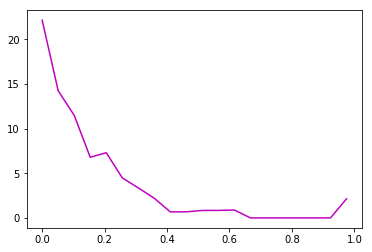

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile, join
import pandas as pd
from scipy.signal import find_peaks

# This is all for reading in the file data 
# It will be changed so that multiple burst histories are read in

with open(r'/Users/beecontreras/Desktop/2019_Duke_TUNL_REU/runs_x100_1/13/LOGS/history.txt', 'r') as f:
    
    info_starts = 0
    data = []
    all_models = []
    
    for line in f:
        
        info_starts += 1
    
        model_info = line.split(" ")    # splits the individual numbers in the lines

        model_info = np.array(list(filter(None, model_info)))[:-1:]
        
        if info_starts >= 7:     # This is where we care about the data
        
            model_elements = model_info.astype(float)

            all_models.append(model_elements)
            
            num_models = len(all_models)
            

star_age = []
log_lum = []

# This creates lists for star age and log luminosity

for i in range(num_models):
    
    star_age.append(all_models[i][1])
    log_lum.append(all_models[i][36])

    
# Changes the above lists into arrays so calculations can be done

star_age = np.array(list(star_age))
log_lum = np.array(list(log_lum)) 
plt.figure(0)

#plt.ylim(0,5.2)
#plt.xlim(.000850660,.00090)
# Plots data from above
plt.plot(star_age, log_lum, 'y*')
plt.ylabel('log luminosity')
plt.xlabel('star age')
plt.title('X-ray Burst Luminosity') 

peaks_x = []
peaks_y = []
x = []
y = []
av_lum = []
total = 0

# Filling lists with differences of luminosity points (i'm not entirely sure about the if statement here - it might be repetitive)
for j in range(len(log_lum) - 1):     
        x.append(log_lum[j]-log_lum[j-1]) 
        y.append(log_lum[j+1]-log_lum[j]) 
        if log_lum[j] > 0 and log_lum[j+1] - log_lum[j] < .01:
            av_lum.append(log_lum[j])
# Finds peaks by saying that if luminosities are increasing and then switch to decreasing at a luminosity point
# then that point is a peak if it's above a certain threshold (4.5) - I might tweak this to make it more
# sure fire and accurate
for k in range(len(x)):
    if x[k] > 0 and y[k] < 0 and log_lum[k] > 4.5:
        peaks_x.append(star_age[k])
        peaks_y.append(log_lum[k])
        
# Potential Fix for any issue with extra peaks included
################################################
#for i in range(len(peaks_x)-1):               #
#    if (peaks_x[i+1] - peaks_x[i]) < .0002:   #
#        if peaks_y[i] < peaks_y[i+1]:         #
#            peaks_y.remove(peaks_y[i])        #
#            peaks_x.remove(peaks_x[i])        #
#        else:                                 #
#            peaks_y.remove(peaks_y[i+1])      #
#            peaks_x.remove(peaks_x[i+1])      #  
################################################

plt.plot(peaks_x, peaks_y, 'x')        
 
sum_lum = 0.
avg_sum = log_lum[5]
count = 1.

blpoint_y_left = [] # will hold luminosity info. for point that is closest to the avg. baseline (blpoint) on the left for each peak
blpoint_x_left = [] # will hold star age info. for point that is closest to the avg. baseline (blpoint) on the left for each peak

blpoint_y_right = [] # will hold luminosity info. for point that is closest to the avg. baseline (blpoint) on the right for each peak
blpoint_x_right = [] # will hold star age info. for point that is closest to the avg. baseline (blpoint) on the right for each peak
#These points will later be plotted in blue

# This starts counting the points along the baseline to find avg. luminosity 
# If the point deviates .3 from the running avg. then it's ignored

for i in range (5, len(star_age)-1):
    if abs(log_lum[i]-avg_sum) < .3 :
        count += 1
        sum_lum = sum_lum + log_lum[i]
        avg_lum = sum_lum / count


peaks_to_avg = []
end_burst = []
burst_fraction = 1/6

# This plots the point at a fraction between the peak and avg. baseline for each purst (black plus sign)
for j in range(len(peaks_y)):
    peaks_to_avg.append(peaks_y[j]-avg_lum)
    plt.plot(peaks_x[j], (peaks_to_avg[j]*(burst_fraction))+avg_lum,'+k')
    end_burst.append((peaks_to_avg[j]*(burst_fraction))+avg_lum)
    

peak_rise = []
start_point = [] 
inc_points = []
dec_points = []
on_decrease = False
on_increase = True

# This goes through all of the points and finds which points of a burst are closest to the avg. baseline
# on either side of the burst's peak
# This becomes very useful later, when finding start and stop points of the x-ray burst

# Finds x & y information for points to the left of the peaks
for i in range(5, len(star_age)-1):
    if log_lum[i] < 2.0 and log_lum[i] > 1.50:
        if log_lum[i+1] - log_lum[i] > 0 and log_lum[i] - log_lum[i-1] > 0:
            on_decrease = False
            inc_points.append(log_lum[i])
        if log_lum[i+1] - log_lum[i] < 0 and log_lum[i] - log_lum[i-1] < 0:
            if on_decrease == False:
                blpoint_y_left.append(min(inc_points, key=lambda x:abs(x-avg_lum)))
                blpoint_x_left.append(star_age[np.where(log_lum == min(inc_points, key=lambda x:abs(x-avg_lum)))])
                inc_points = []
                on_decrease = True
                
# Finds x & y information for points to the right of the peaks                
for i in range(5, len(star_age)-1):
    if log_lum[i] < 2.0 and log_lum[i] > 1.50:
        if log_lum[i+1] - log_lum[i] < 0 and log_lum[i] - log_lum[i-1] < 0:
            on_increase = False
            dec_points.append(log_lum[i])
        if log_lum[i+1] - log_lum[i] > 0 and log_lum[i] - log_lum[i-1] > 0:
            if on_increase == False:
                blpoint_y_right.append(min(dec_points, key=lambda x:abs(x-avg_lum)))
                blpoint_x_right.append(star_age[np.where(log_lum == min(dec_points, key=lambda x:abs(x-avg_lum)))])
                dec_points = []
                on_increase = True 
        if i == len(star_age) - 2:
                blpoint_y_right.append(log_lum[-1])
                blpoint_x_right.append(star_age[-1])
                
# This takes in points on either side of the peaks up to some specified fraction
# between the peak and the avg. baseline.

start_point_y = []
start_point_x = []
peak_rise_y = []
peak_rise_x = []
log_rise = []

# Finds the starting points - looking at points between a burst's peak and the closest point
# the burst has to the avg. baseline 
for k in range(len(peaks_y)):
    for i in range(len(star_age)):
        if star_age[i] < peaks_x[k] and star_age[i] > blpoint_x_left[k]:
            peak_rise_y.append(abs(log_lum[i] - end_burst[k]))
            log_rise.append(log_lum[i])
            peak_rise_x.append(star_age[i])
    start_point_y.append(log_rise[peak_rise_y.index(min(peak_rise_y))]) 
    start_point_x.append(peak_rise_x[peak_rise_y.index(min(peak_rise_y))])
    peak_rise_y = []
    log_rise = []
    peak_rise_x = []
    

stop_point_y = []
stop_point_x = []
peak_fall_y = []
peak_fall_x = []
log_fall = []

# Finds the stopping points the same way as done above for starting points
for k in range(len(peaks_y)):
    for i in range(len(star_age)):
        if star_age[i] > peaks_x[k] and star_age[i] < blpoint_x_right[k]:
            #print(k)
            peak_fall_y.append(abs(log_lum[i] - end_burst[k]))
            log_fall.append(log_lum[i])
            peak_fall_x.append(star_age[i])
    stop_point_y.append(log_fall[peak_fall_y.index(min(peak_fall_y))]) 
    stop_point_x.append(peak_fall_x[peak_fall_y.index(min(peak_fall_y))])
    peak_fall_y = []
    log_fall = []
    peak_fall_x = []
    
# These plot the start points (green) and the stop points (red)
plt.plot(start_point_x, start_point_y, '*g')
plt.plot(stop_point_x, stop_point_y, '*r')

# This plots the points closest to the avg. baseline on either side of the peak
plt.plot(blpoint_x_left, blpoint_y_left, 'b*')
plt.plot(blpoint_x_right, blpoint_y_right, 'b*')

# Plots the avg. basline
plt.plot(star_age, np.ones(len(star_age))*avg_lum, 'm' )
plt.figure(1)

####################################################################################
# Puts sequential x-ray bursts on top of each other

xray_bursts_x = []
xray_bursts_y = []
bursts_y = []
bursts_x = []

# Takes in all of the points inbetween the start and stop points
# along both the x and y axis
for j in range(len(stop_point_x)):
    for i in range(len(star_age)):
        if star_age[i] >= start_point_x[j] and star_age[i] <= stop_point_x[j]:
            xray_bursts_y.append(log_lum[i])
            xray_bursts_x.append(star_age[i])

    bursts_y.append(xray_bursts_y)
    bursts_x.append(xray_bursts_x)
    xray_bursts_x = []
    xray_bursts_y = []
    
# This starts all of the burst plots at zero
# by subtracting all points by the star age the 
#particular burst begins at
# and gives them a fixed width of one (figure out unit)
for i in range(len(bursts_x)): 
    start = bursts_x[i][0]
    for j in range(len(bursts_x[i])):
        bursts_x[i][j] = bursts_x[i][j] - start
    fixed_width = bursts_x[i][-1]
    for j in range(len(bursts_x[i])):
        bursts_x[i][j] = bursts_x[i][j] / fixed_width

# Plots start and stop point        
for i in range(len(bursts_y)-1):
    plt.plot(bursts_x[i],bursts_y[i])
plt.figure(2)

################################################################################ 
# This put all of the points into bins and then averages the bins over all bursts
burst_hist = []

for i in range(len(bursts_y)-1):
    burst_hist.append(np.histogram(bursts_x[i], 20,weights = bursts_y[i]))
    # Here, we say 20 bins because the number of points ranges from ~23 - 31 and you want less bins than points
    
for i in range(len(bursts_y)-1):
    plt.bar(burst_hist[i][1][:-1:], burst_hist[i][0], width = 0.05, align = 'edge')
plt.figure(3)    
count = 1
burst_avg = []
point_sums = 0

# This is where the bins are averaged over the bursts
for i in range(len(burst_hist[0][0])):
    count = 0
    for j in range(len(bursts_y)-1):
        point_sums += burst_hist[j][0][i]
        count += 1
    point_sums = point_sums/count
    burst_avg.append(point_sums)
    point_sums = 0
    
x_axis = np.linspace(0.0, 0.975, len(burst_hist[0][0]))
plt.plot(x_axis, burst_avg, 'm')

In [130]:
# Burst Frequency

peak_dist_sum = 0

for i in range(len(peaks_x)-1):
    
    peak_dist_sum += (peaks_x[i+1]- peaks_x[i])
    #gets sum distance between all peaks

burst_frequency = peak_dist_sum / (len(peaks_x)-1)
# divides by number of peaks (minus one b/c )


print(burst_frequency)

0.00027366201920625647


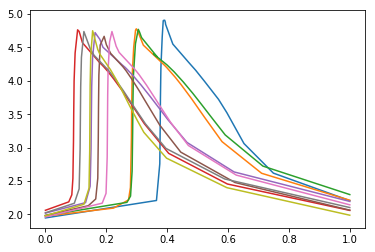

In [92]:
# The stuff below is the same as most of the code above. It's just seperate, because it's easier to section of subtasks
# into different cells. !!!! This can all be ignored !!!!
"""
xray_bursts_x = []
xray_bursts_y = []
bursts_y = []
bursts_x = []

for j in range(len(stop_point_x)):
    for i in range(len(star_age)):
        if star_age[i] >= start_point_x[j] and star_age[i] <= stop_point_x[j]:
            xray_bursts_y.append(log_lum[i])
            xray_bursts_x.append(star_age[i])
    #print(xray_bursts_y ,'\n\n\n')
    bursts_y.append(xray_bursts_y)
    bursts_x.append(xray_bursts_x)
    xray_bursts_x = []
    xray_bursts_y = []
#print(bursts_x[0][0])
#for j in range(len(stop_point_x)):
#    print(stop_point_x[j] - start_point_x[j])
    
    
for i in range(len(bursts_x)): 
    start = bursts_x[i][0]
    for j in range(len(bursts_x[i])):
        bursts_x[i][j] = bursts_x[i][j] - start
    fixed_width = bursts_x[i][-1]
    for j in range(len(bursts_x[i])):
        bursts_x[i][j] = bursts_x[i][j] / fixed_width
        
for i in range(len(bursts_y)-1):
    plt.plot(bursts_x[i],bursts_y[i])
    #print(len(bursts_x[i]),len(bursts_y[i]))
    #print(bursts_x[i],'\n\n',bursts_y[i], '\n\n')
"""

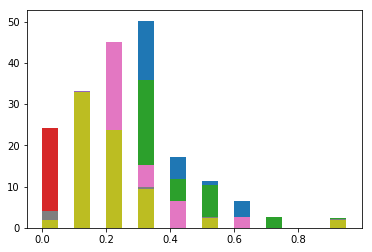

In [95]:
"""
burst_hist = []
for i in range(len(bursts_y)-1):
    burst_hist.append(np.histogram(bursts_x[i], weights = bursts_y[i]))
    
for i in range(len(bursts_y)-1):
    plt.bar(burst_hist[i][1][:-1:], burst_hist[i][0], width = 0.05, align = 'edge')
"""

In [96]:
"""
count = 1
burst_avg = []
point_sums = 0
for i in range(len(burst_hist[0][0])):
    count = 0
    for j in range(len(bursts_y)-1):
        point_sums += burst_hist[j][0][i]
        count += 1
    point_sums = point_sums/count
    burst_avg.append(point_sums)
    point_sums = 0
"""

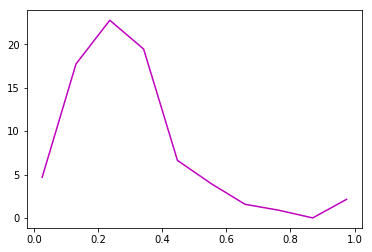

In [97]:
"""
x_axis = np.linspace(0.025, 0.975, len(burst_hist[0][0]))
plt.plot(x_axis, burst_avg, 'm')
"""